Starting transcription...


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: CPU

Audio Waveform:


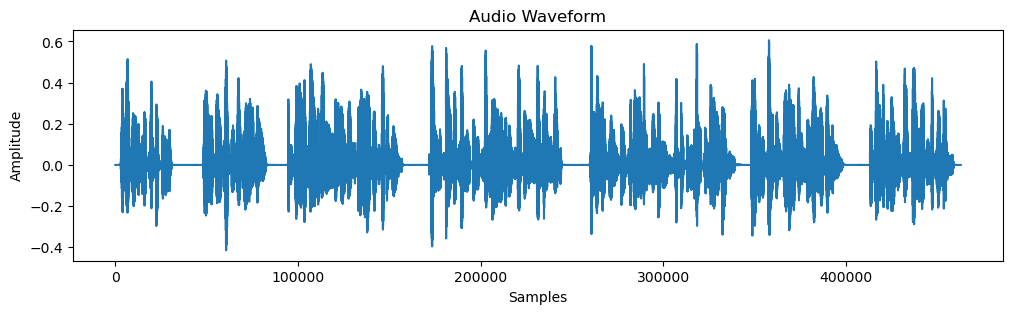


Play the audio:



Result: THE PSYCHOLOGY OF COMFORT FOOD WHY DO WE CRAVE CHOCOLATES AFTER A BAD DAY EXPLORE HOW CHILDHOOD MEMORIES AND EMOTIONS WYRE OURE TASTE PREFERENCES SCIENTISTS FOUND THAT SUGARY FOODS TEMPORARILY REDUCE STRESS HORMONES BY TWENTY PER CENT FROM GRANDMA'S CHICKEN SOUP TO MIDNIGHT ICE CREAM BINGES COMFORT FOODS ACT AS EDIBLE HUGS BUT IS IT NASTALGIA OR BIOCHEMISTRY DRIVING OUR CRAVINGS DISCOVER WHAT YOUR GO TO SNACK SAYS ABOUT YOUR SUBCONSCIOUS


In [7]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import librosa
import numpy as np
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Audio, display  

#  warnings
warnings.filterwarnings("ignore", message="Some weights of Wav2Vec2ForCTC")
warnings.filterwarnings("ignore", category=FutureWarning)  # For autocast warning

def transcribe_audio(audio_path):
    try:
        
        if not Path(audio_path).exists():
            raise FileNotFoundError(f"Audio file not found: {audio_path}")
        
        #  using facebook's WAV2VEC2.O
        processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
        model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
        
        #   CPU detection)
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = model.to(device)
        print(f"Using device: {device.upper()}")
        
   
        try:
            speech, rate = librosa.load(audio_path, sr=16000)
        except Exception as e:
            print(f"Librosa failed: {e}. Trying pydub...")
            from pydub import AudioSegment
            audio = AudioSegment.from_file(audio_path)
            speech = audio.set_frame_rate(16000).get_array_of_samples()
            speech = np.array(speech, dtype=np.float32) / 32768  # Convert to float32
            rate = 16000
        
        #Display Audio  
        print("\nAudio Waveform:")
        plt.figure(figsize=(12, 3))
        plt.plot(speech)
        plt.title("Audio Waveform")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.show()
        
        print("\nPlay the audio:")
        display(Audio(speech, rate=rate))  
        
        
        with torch.no_grad():
            if device == "cuda":
                with torch.amp.autocast(device_type="cuda"):
                    inputs = processor(speech, sampling_rate=rate, return_tensors="pt").to(device)
                    logits = model(**inputs).logits
            else:
                inputs = processor(speech, sampling_rate=rate, return_tensors="pt").to(device)
                logits = model(**inputs).logits
        
      
        predicted_ids = torch.argmax(logits, dim=-1)
        return processor.batch_decode(predicted_ids)[0]
    
    except Exception as e:
        return f"Transcription failed: {str(e)}"

# Usage
audio_path = "psychology.mp3"  
if Path(audio_path).exists():
    print("Starting transcription...")
    result = transcribe_audio(audio_path)
    print("\nResult:", result)
else:
    print(f"File not found: {audio_path}")